# Blaseball ELO System
## By @BirdWife#7151 [@Birdwife_](https://www.twitter.com/BirdWife_)

Are Crabs Good? Let's find out using Elo!

A player's new rating after a tournament is calculated :

Rn = Ro + (K/2)(W - L + (Sum of rating differences/2C))
Rn is the new rating, Ro is the old rating. W and L are the number of wins and losses. A rating difference is the opponent's rating minus the player's rating, not the other way around.

C will determine how spaced out the ratings are, i.e. the standard deviation. It appears that 200 is commonly used.

K will determine how much of an effect each game has. FIDE uses 30, and 20 once a player reaches IM. http://www.fide.com/component/content/article/1-fide-news/3963-rating-regulations-the-k-factor

A draw is 0 wins and 0 losses.


Elo devised a linear approximation to his full system. With that method, a player's new rating is

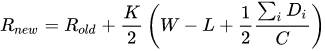

where Rnew and Rold are the player's new and old rating respectively, Di is the opponent's rating minus the player's rating, W is the number of wins, L is the number of losses, C = 200 and K = 32.



In [62]:
# Imports and globals

from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns=None
pd.options.display.max_rows=None

sns.set_style('darkgrid')

#### Getting and saving our game data

In [63]:
req = requests.get(f'https://api.sibr.dev/chronicler/v1/games')

In [64]:
x = req.json()

In [65]:
games = pd.json_normalize(x['data'])

In [66]:
games.to_csv('./data/games.csv',index=False)

#### Exploring to ensure we have what we need

In [67]:
games.head()

gameId                    startTime  \
0  5947b5f0-7a90-4896-bfa6-fd011a36fba7  2020-11-17T22:00:02.891029Z   
1  85ba2b4e-64ec-4ab4-8d68-a9951409aaab  2020-11-17T22:00:06.877036Z   
2  9e3111de-67ae-451e-864f-2f9ee8efb5c4  2020-11-17T22:00:02.891029Z   
3  c906cb01-3214-4d70-a953-e8575f4fb450  2020-11-17T22:00:02.891029Z   
4  caef7953-e9eb-4686-9f78-45271f7ed335  2020-11-17T22:00:06.877036Z   

                       endTime                               data.id  \
0  2020-11-17T22:25:23.190674Z  5947b5f0-7a90-4896-bfa6-fd011a36fba7   
1  2020-11-17T22:28:31.331468Z  85ba2b4e-64ec-4ab4-8d68-a9951409aaab   
2  2020-11-17T22:20:47.009897Z  9e3111de-67ae-451e-864f-2f9ee8efb5c4   
3  2020-11-17T22:25:59.324029Z  c906cb01-3214-4d70-a953-e8575f4fb450   
4  2020-11-17T22:22:19.021837Z  caef7953-e9eb-4686-9f78-45271f7ed335   

   data.day  data.phase                            data.rules  data.shame  \
0         0           6  4ae9d46a-5408-460a-84fb-cbd8d03fff6c       False   
1         0           6  4ae9d46a-5408-460a-84fb-cbd8d03fff6c       False   
2         0           6  4ae9d46a-5408-460a-84fb-cbd8d03fff6c       False   
3         0           6  4ae9d46a-5408-460a-84fb-cbd8d03fff6c       False   
4         0           6  4ae9d46a-5408-460a-84fb-cbd8d03fff6c       False   

   data.inning  data.season  data.weather  data.awayOdds  data.awayOuts  \
0            8           -1          15.0       0.509359            3.0   
1            8           -1          15.0       0.494244            3.0   
2            8           -1          15.0       0.536428            3.0   
3            8           -1          15.0       0.468413            3.0   
4            8           -1          15.0       0.483632            3.0   

                          data.awayTeam  data.homeOdds  data.homeOuts  \
0  4d921519-410b-41e2-882e-9726a4e54a6a       0.490641            3.0   
1  70eab4ab-6cb1-41e7-ac8b-1050ee12eecc       0.505756            3.0   
2  9e42c12a-7561-42a2-b2d0-7cf81a817a5e       0.463572            3.0   
3  3b0a289b-aebd-493c-bc11-96793e7216d5       0.531587            3.0   
4  d8f82163-2e74-496b-8e4b-2ab35b2d3ff1       0.516368            3.0   

                          data.homeTeam  \
0  49181b72-7f1c-4f1c-929f-928d763ad7fb   
1  a3ea6358-ce03-4f23-85f9-deb38cb81b20   
2  7fcb63bc-11f2-40b9-b465-f1d458692a63   
3  e3f90fa1-0bbe-40df-88ce-578d0723a23b   
4  4e5d0063-73b4-440a-b2d1-214a7345cf16   

                              data.outcomes  data.awayBalls  data.awayBases  \
0                                        []             4.0             4.0   
1                                        []             4.0             4.0   
2  [GM was Percolated by the Tractor Bean!]             4.0             4.0   
3                                        []             4.0             4.0   
4                                        []             4.0             4.0   

   data.awayScore  data.finalized  data.gameStart  data.homeBalls  \
0             4.0            True            True             4.0   
1            12.0            True            True             4.0   
2             0.0            True            True             4.0   
3             7.0            True            True             4.0   
4             4.5            True            True             4.0   

   data.homeBases  data.homeScore  data.playCount  \
0             4.0             9.0           277.0   
1             4.0             4.0           305.0   
2             4.0             4.0           246.0   
3             4.0             2.0           285.0   
4             4.0             2.5           262.0   

                         data.statsheet  data.atBatBalls data.awayBatter  \
0  824ea7be-18b3-496f-b731-1fa86c7b07f2                0            None   
1  24236312-3e9e-4bdb-a039-a5da0793deef                0            None   
2  f2a2b630-ced4-4ed2-b15d-04a5228ce612                0            None   
3  4d3a6538-5b5a-4081-9ee5-2fe16027f6b0   

#### Create an outcome flag and some cleaning to make things easier

In [68]:
# Drop coffee cup games
games = games[(games['data.season'] != 0) & (games['data.season'] != -1)]

# Outcome flags and nickname cleaning
games['data.awayTeamNickname'] = games['data.awayTeamNickname'].map(lambda x: 'Dale' if x == 'Dalé' else 'Wild Wings' if x == 'Mild Wings' else x)
games['data.homeTeamNickname'] = games['data.homeTeamNickname'].map(lambda x: 'Dale' if x == 'Dalé' else 'Wild Wings' if x == 'Mild Wings' else x)

winner = []
loser = []
for index, entry in games.iterrows():
    winner.append(entry['data.awayTeamNickname'] if entry['data.awayScore'] > entry['data.homeScore'] else entry['data.homeTeamNickname'])
    loser.append(entry['data.awayTeamNickname'] if entry['data.awayScore'] < entry['data.homeScore'] else entry['data.homeTeamNickname'])


games['winner'] = winner
games['loser'] = loser

# Incrementing day and season up 1 for clarity
games['data.day'] = games['data.day'].map(lambda x: x + 1)
games['data.season'] = games['data.season'].map(lambda x: x + 1)

# Removing games where scores are both zero

games = games[~(games['winner'] == games['loser'])]

In [69]:
games['winner'].value_counts()

Tigers           807
Crabs            700
Moist Talkers    692
Garages          685
Shoe Thieves     682
Pies             678
Millennials      671
Firefighters     668
Steaks           657
Spies            655
Jazz Hands       653
Lovers           645
Breath Mints     611
Sunbeams         600
Flowers          599
Wild Wings       593
Magic            570
Dale             558
Fridays          535
Tacos            517
Lift             121
Mechanics         59
Georgias          54
Worms             46
Name: winner, dtype: int64

In [70]:
games['loser'].value_counts()

Tacos            741
Fridays          719
Dale             681
Magic            679
Sunbeams         673
Wild Wings       670
Flowers          660
Breath Mints     648
Lovers           637
Jazz Hands       635
Shoe Thieves     622
Millennials      615
Firefighters     614
Spies            613
Garages          611
Pies             606
Steaks           606
Moist Talkers    581
Tigers           518
Crabs            403
Lift             230
Worms            105
Georgias          97
Mechanics         92
Name: loser, dtype: int64

#### Creating Elo Table

In [71]:
color_table = list(zip(games['data.homeTeamNickname'], games['data.homeTeamColor']))
color_table = list(set(color_table))
color_table.sort()
color_dict = dict(color_table)
team_color_index = {}
for i, team in enumerate(color_dict):
    team_color_index[team] = i
colors = [j for i, j in color_table]


In [72]:
teams = list(games['winner'].unique())
teams.sort()

elo_table = {
    'season' : [-1],
    'day' : [-1],
    'is_postseason' : [False],
    'incorrect_preds': 0,
    'daily_incorrect_preds':[0]
}

for team in teams:
    elo_table[team] = [500]

elo_table = pd.DataFrame(elo_table)
elo_table

season  day  is_postseason  incorrect_preds  daily_incorrect_preds  \
0      -1   -1          False                0                      0   

   Breath Mints  Crabs  Dale  Firefighters  Flowers  Fridays  Garages  \
0           500    500   500           500      500      500      500   

   Georgias  Jazz Hands  Lift  Lovers  Magic  Mechanics  Millennials  \
0       500         500   500     500    500        500          500   

   Moist Talkers  Pies  Shoe Thieves  Spies  Steaks  Sunbeams  Tacos  Tigers  \
0            500   500           500    500     500       500    500     500   

   Wild Wings  Worms  
0         500    500

#### Elo Update Formula

In [73]:
def update_elo(home_team_elo, home_team_score, away_team_elo, away_team_score, k=20, c = 200):
#     if home_team_score > away_team_score:
#         home_team_score = 1
#         away_team_score = 0
#     else:
#         home_team_score = 0
#         away_team_score = 1
    new_home_team_elo = home_team_elo + (k/2) * (home_team_score - away_team_score + ((away_team_elo - home_team_elo)/(2*c)))
    new_away_team_elo = away_team_elo + (k/2) * (away_team_score - home_team_score + ((home_team_elo - away_team_elo)/(2*c)))
    
    better_team_lost = True
    if np.argmax([home_team_elo, away_team_elo]) == np.argmax([home_team_score,away_team_score]):
        better_team_lost = False
    
    return new_home_team_elo, new_away_team_elo, int(better_team_lost)

In [79]:
def update_elo_table(games = games, elo_table = elo_table, k=24, c=325):
    current_season = 0
    current_day = 0
    is_postseason = False
    date_index = 0
    error = 0
    daily_error = 0
    for index, game in games.iterrows():
        ## Seasonal reset
        if game['data.season'] != current_season and current_season != 0:
            seasonal_reset_elos = [game['data.season'],0,False]
            
            for col in elo_table.columns[5:]:
                seasonal_reset_elos.append(elo_table.loc[date_index,col]*1)
            
            seasonal_reset_elos = pd.Series(seasonal_reset_elos,index=elo_table.columns)
            elo_table = elo_table.append(seasonal_reset_elos, ignore_index=True)
            elo_table.reset_index(inplace=True, drop=True)
            
            date_index += 1
            error = 0
            daily_error = 0
            
        if game['data.awayScore'] == 0 and game['data.homeScore'] == 0:
            return(elo_table)
        
        # If we've entered a new day, add a row
        if game['data.season'] != current_season or game['data.day'] != current_day or game['data.isPostseason'] != is_postseason:
            
            current_season = game['data.season']
            current_day = game['data.day']
            is_postseason = game['data.isPostseason']
            date_index += 1
            error = 0
            daily_error = 0
            
            # Copy the previous row first to ensure we don't introduce NaNs during playoffs
            elo_table = elo_table.append(elo_table.iloc[date_index-1,0:23])
            elo_table.reset_index(inplace=True, drop=True)
            
            elo_table.loc[date_index, 'season'] = current_season
            elo_table.loc[date_index, 'day'] = current_day
            elo_table.loc[date_index, 'is_postseason'] = is_postseason
            
        # Now make our elo table updates
        home_team = game['data.homeTeamNickname']
        away_team = game['data.awayTeamNickname']
        
        elo_table.loc[date_index, home_team], elo_table.loc[date_index, away_team], error = update_elo(elo_table.loc[date_index-1,home_team],
                                                                game['data.homeScore'],
                                                                elo_table.loc[date_index-1,away_team],
                                                                game['data.awayScore'],k=k,c=c)
        
        elo_table.loc[date_index, 'incorrect_preds'] += error
        daily_error += error
        
        elo_table.loc[date_index, 'daily_incorrect_preds'] = daily_error
        
        for team in elo_table:
            if pd.isnull(elo_table.loc[date_index,team]):
                elo_table.loc[date_index,team] = elo_table.loc[date_index-1,team]
        
    return elo_table
            
            
        

In [80]:
new_elo_table = update_elo_table()

In [81]:
new_elo_table.tail(100)

season  day  is_postseason  incorrect_preds  daily_incorrect_preds  \
1325      13   69          False             5123                      5   
1326      13   70          False             5125                      2   
1327      13   71          False             5130                      5   
1328      13   72          False             5134                      4   
1329      13   73          False             5139                      5   
1330      13   74          False             5143                      4   
1331      13   75          False             5147                      4   
1332      13   76          False             5156                      9   
1333      13   77          False             5162                      6   
1334      13   78          False             5168                      6   
1335      13   79          False             5174                      6   
1336      13   80          False             5179                      5   
1337      13   81          False             5182                      3   
1338      13   82          False             5188                      6   
1339      13   83          False             5192                      4   
1340      13   84          False             5196                      4   
1341      13   85          False             5203                      7   
1342      13   86          False             5209                      6   
1343      13   87          False             5217                      8   
1344      13   88          False             5222                      5   
1345      13   89          False             5227                      5   
1346      13   90          False             5233                      6   
1347      13   91          False             5242                      9   
1348      13   92          False             5246                      4   
1349      13   93          False             5252                      6   
1350      13   94          False             5260                      8   
1351      13   95          False             5263                      3   
1352      13   96          False             5271                      8   
1353      13   97          False             5277                      6   
1354      13   98          False             5284                      7   
1355      13   99          False             5289                      5   
1356      13  100           True             5289                      0   
1357      13  101           True             5290                      1   
1358      13  102           True             5290                      0   
1359      13  103           True             5291                      1   
1360      13  104           True             5292                      1   
1361      13  105           True             5293                      1   
1362      13  106           True             5294                      1   
1363      13  107           True             5295                      1   
1364      13  109           True             5295                      0   
1365      13  110           True             5296                      1   
1366      13  111           True             5296                      0   
1367      13  112           True             5297                      1   
1368      13  113           True             5298                      1   
1369      13  114           True             5298                      0   
1370      13  115           True             5298                      0   
1371      13  116           True             5298                      0   
1372      14    0          False             5298                      0   
1373      14    1          False             5301                      3   
1374      14    2          False             5309                      8   
1375      14    3          False             5314                      5   
1376      14    4          False             5318     

In [98]:
games[games['data.season']==14]

(624, 84)

In [101]:
1-(new_elo_table[new_elo_table['season']==14]['daily_incorrect_preds'].sum()/624)

0.5673076923076923

In [22]:
new_elo_table.loc[max(new_elo_table.index),'incorrect_preds']

5552

In [23]:
(len(list(range(10,51,10))) * len(list(range(50,501,50))) * 30)/60

25.0

In [57]:
gridsearch_results = {
    'k':[],
    'c':[],
    'error':[]
}
for k in range(15,25):
    for c in range(250,351,25):
        elos = update_elo_table(k=k,c=c)
        
        gridsearch_results['k'].append(k)
        gridsearch_results['c'].append(c)
        gridsearch_results['error'].append(elos.loc[max(elos.index),'incorrect_preds'])

In [58]:
gridsearch_results = pd.DataFrame(gridsearch_results)

<AxesSubplot:xlabel='k', ylabel='c'>

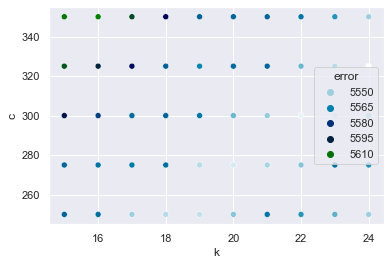

In [59]:
sns.scatterplot(data=gridsearch_results, x='k',y='c', hue='error', palette='ocean_r')

In [60]:
gridsearch_results[gridsearch_results['error'] == min(gridsearch_results['error'])]

k    c  error
48  24  325   5541

In [61]:
from IPython.lib.display import Audio
import numpy as np

framerate = 4410
play_time_seconds = 1

t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
audio_data = np.sin(2*np.pi*300*t) + np.sin(2*np.pi*240*t)
Audio(audio_data, rate=framerate, autoplay=True)

#### Plots and Figures

All-time ELO ratings:

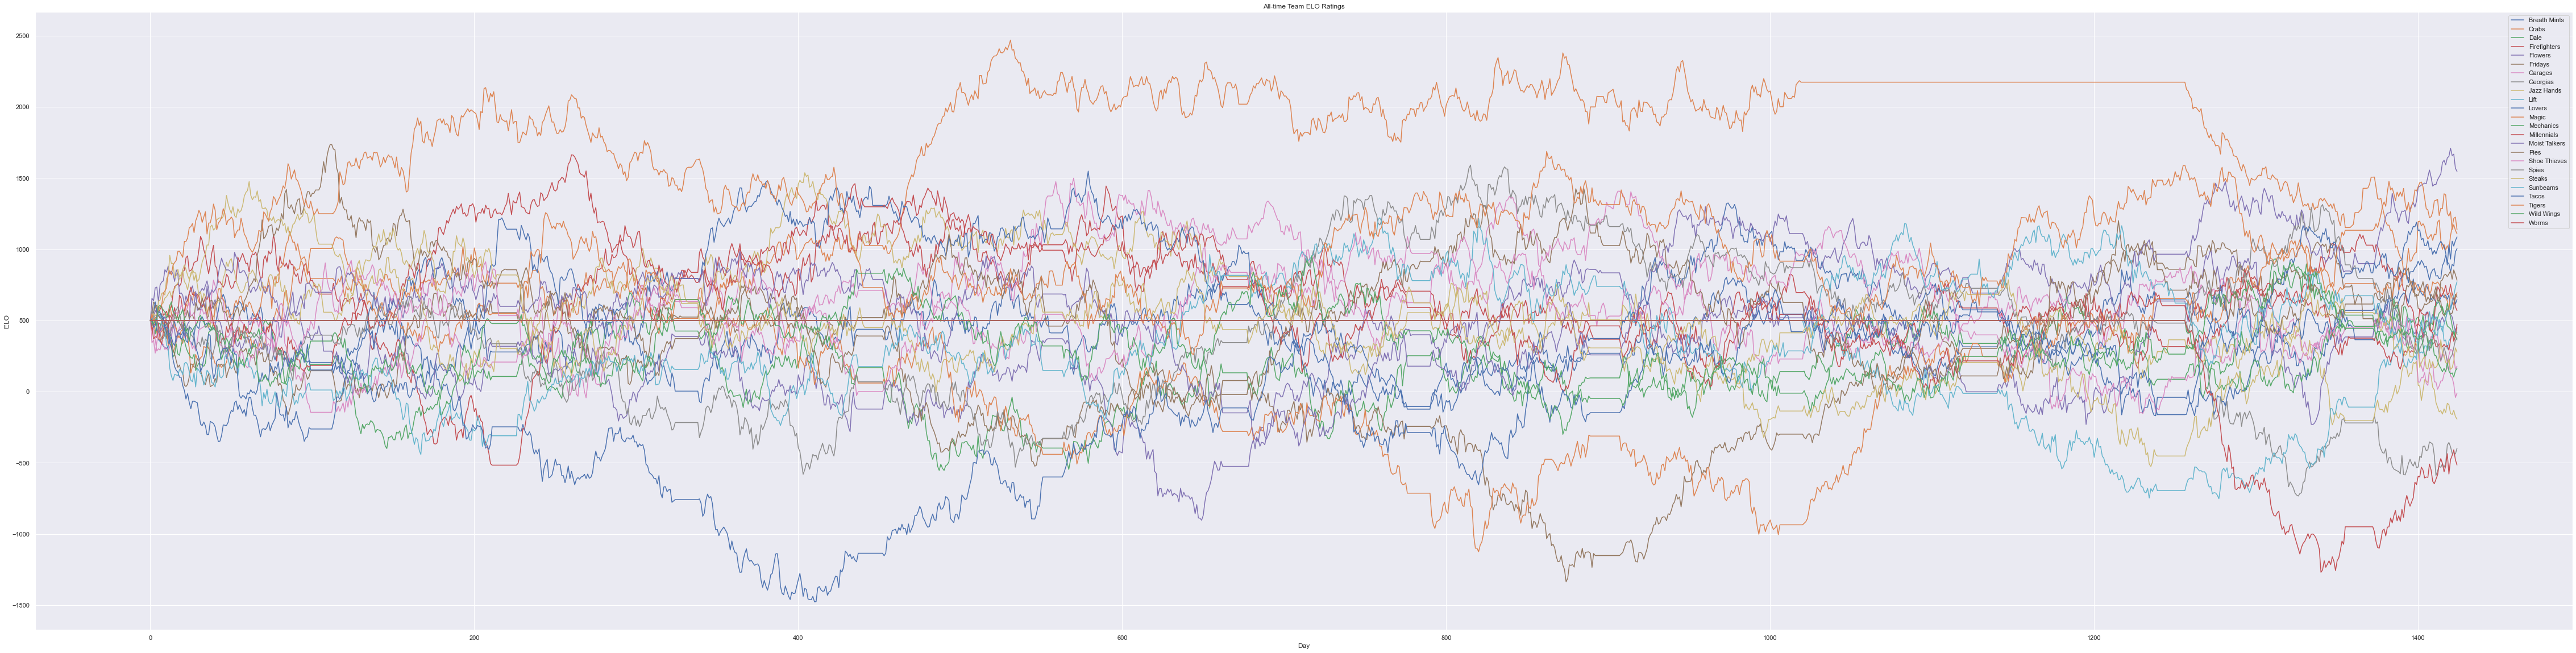

In [85]:
plt.figure(figsize=(80,20))
for i, team in enumerate(teams):
    sns.lineplot(x=new_elo_table.index, y=new_elo_table[team], palette = sns.color_palette(colors,i))
plt.legend(teams, title_fontsize='xx-large')
plt.title('All-time Team ELO Ratings')
plt.xlabel('Day')
plt.ylabel('ELO');

Season 9 Elo Ratings:

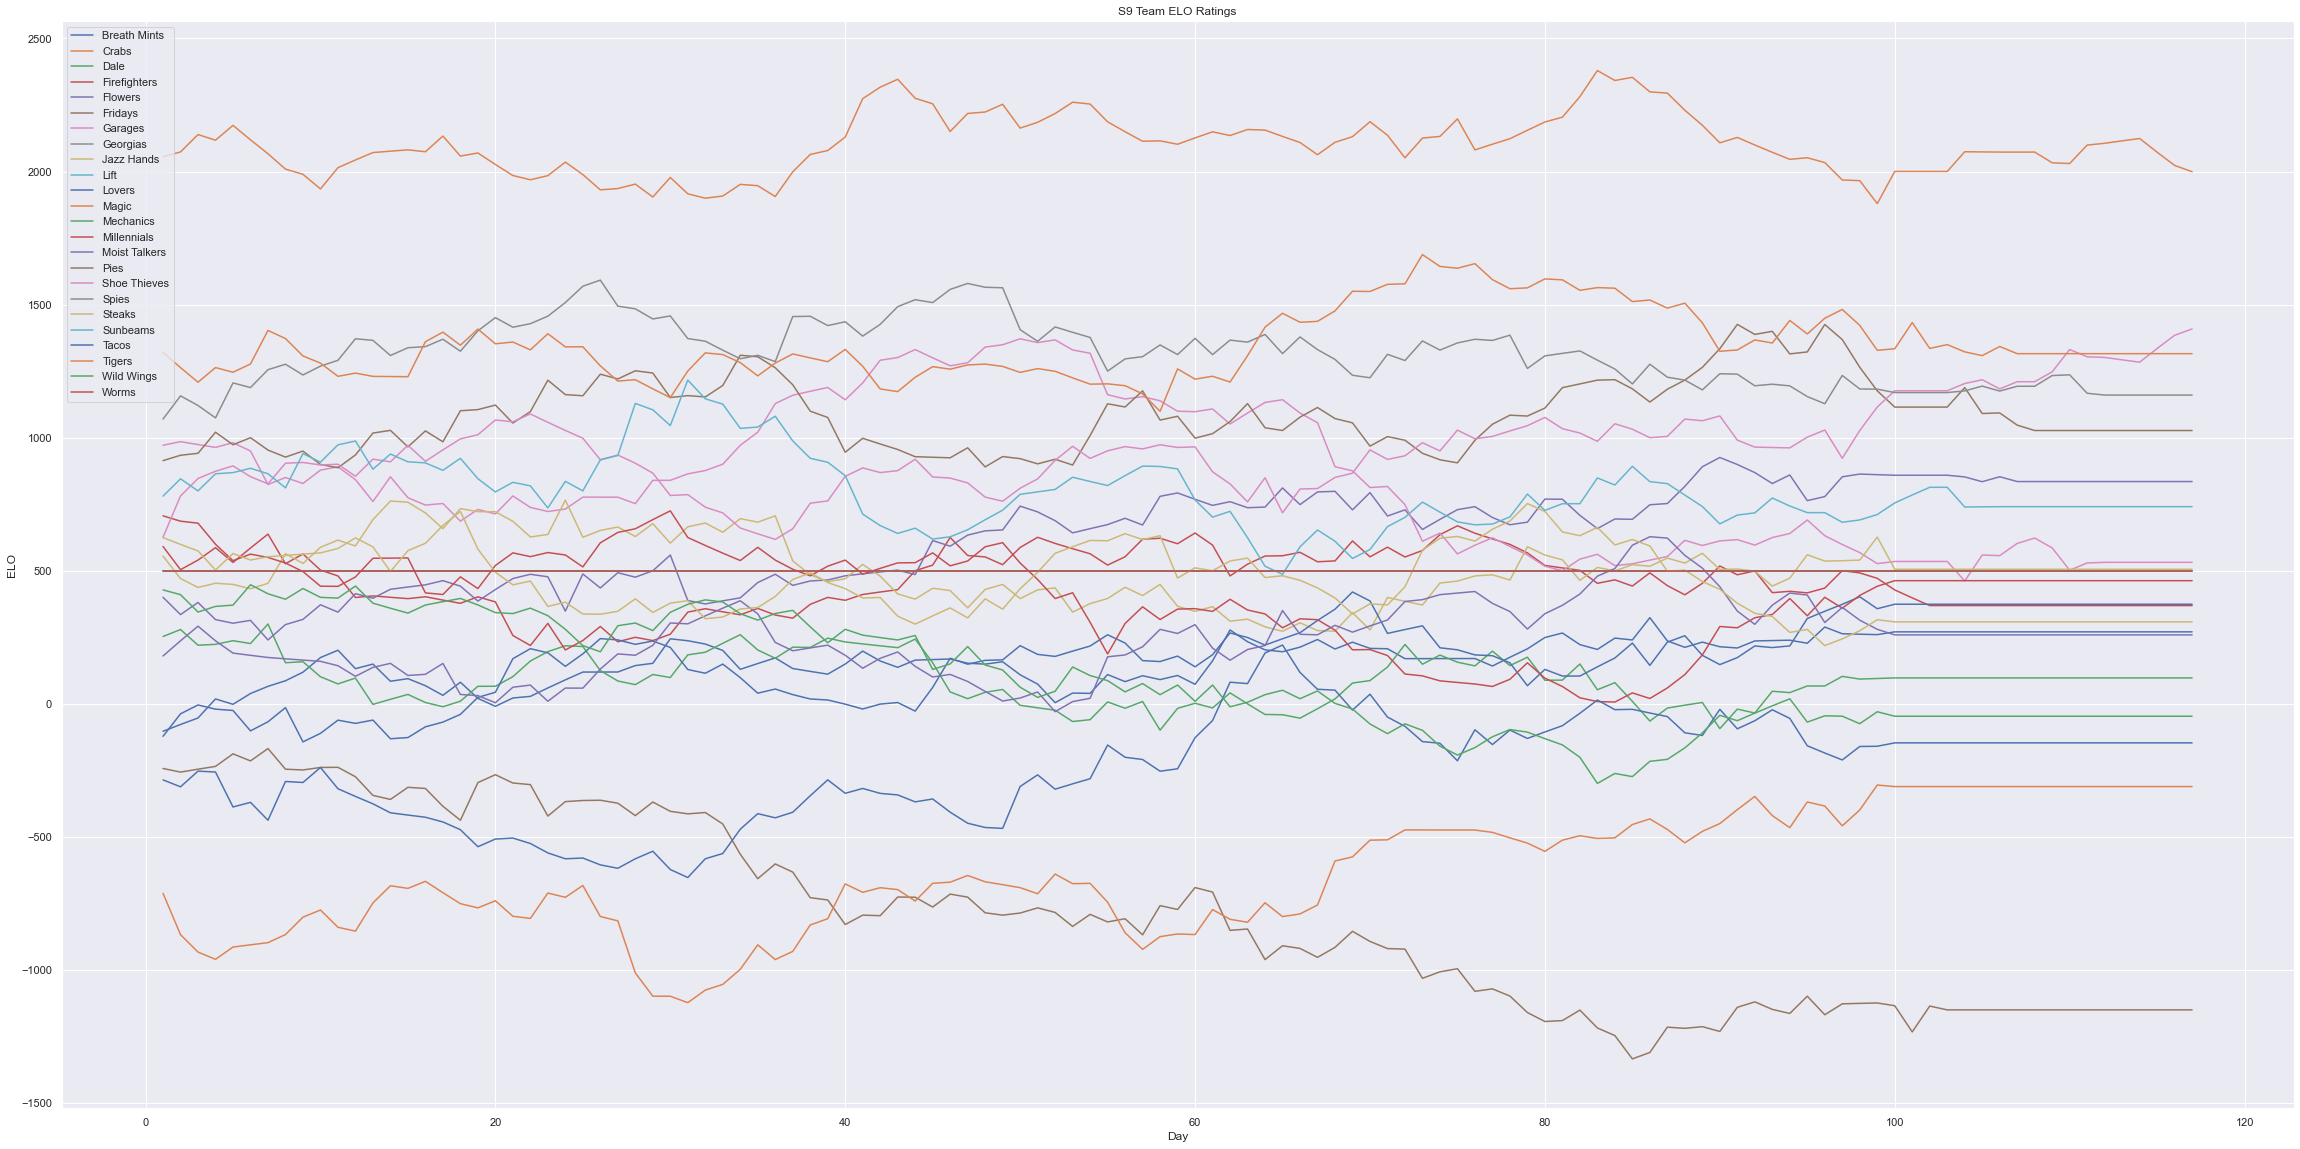

In [86]:
s9_elo = new_elo_table[new_elo_table['season'] == 9]
s9_elo.reset_index(inplace=True,drop=True)
s9_elo.index += 1

plt.figure(figsize=(40,20))
for i, team in enumerate(teams):
    sns.lineplot(x=s9_elo.index, y=s9_elo[team], palette = sns.color_palette(colors,i))
plt.legend(teams, title_fontsize='xx-large')
plt.title('S9 Team ELO Ratings')
plt.xlabel('Day')
plt.ylabel('ELO');

Season 10 ELO Ratings:

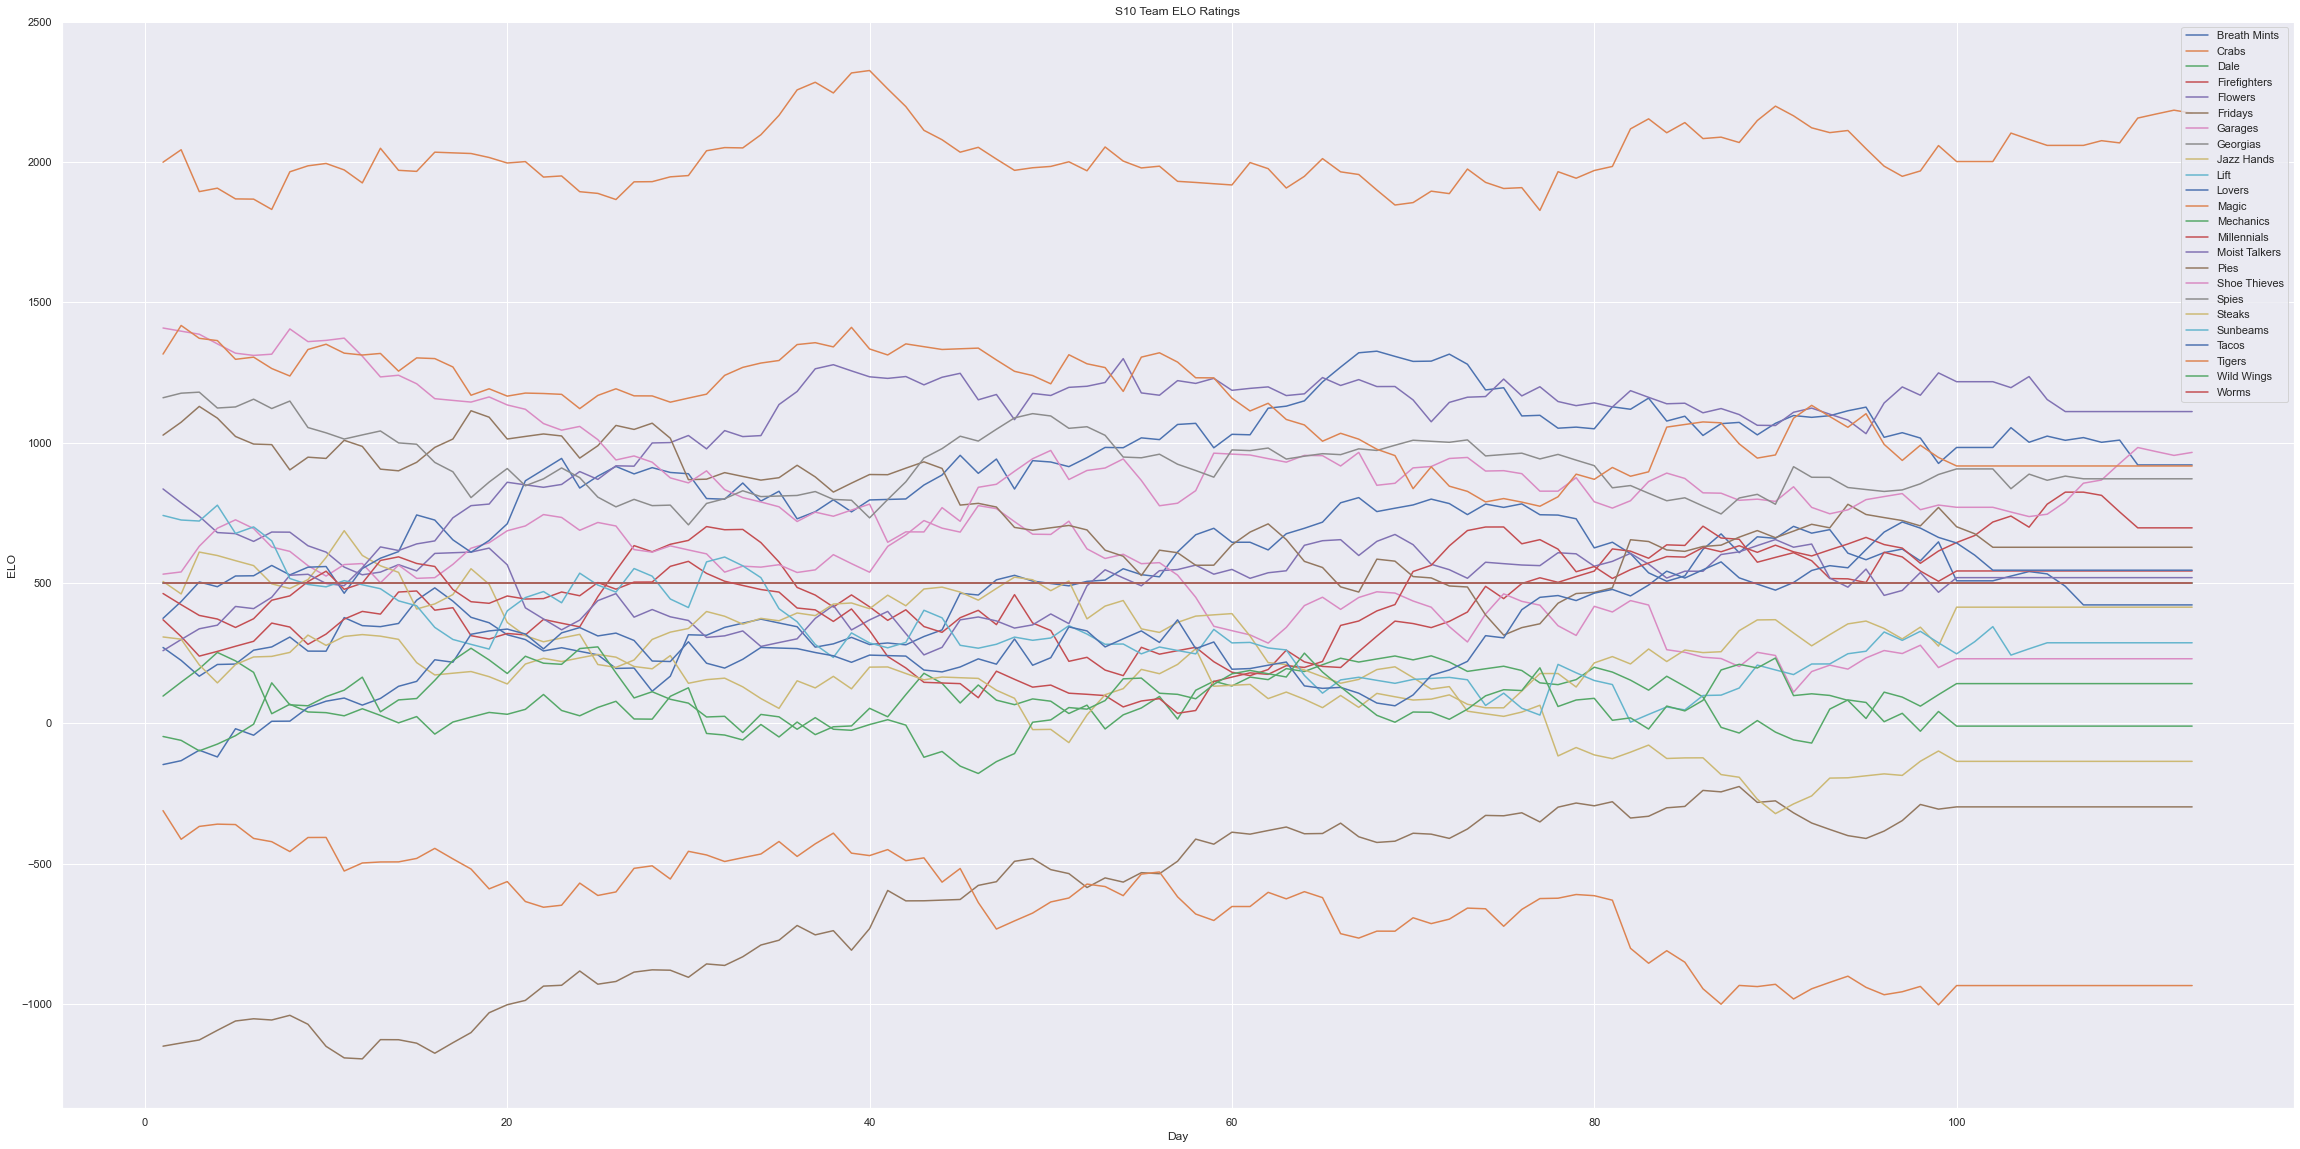

In [87]:
s10_elo = new_elo_table[new_elo_table['season'] == 10]
s10_elo.reset_index(inplace=True,drop=True)
s10_elo.index += 1

plt.figure(figsize=(40,20))
for i, team in enumerate(teams):
    sns.lineplot(x=s10_elo.index, y=s10_elo[team], palette = sns.color_palette(colors,i))
plt.legend(teams, title_fontsize='xx-large')
plt.title('S10 Team ELO Ratings')
plt.xlabel('Day')
plt.ylabel('ELO');

Season 10 Elo Ratings (Current Top 5 Only):

In [88]:
new_elo_table.iloc[-1,3:].sort_values(ascending=False)

incorrect_preds             5568
Moist Talkers            1547.02
Magic                    1138.48
Tigers                   1108.83
Tacos                    1086.82
Lovers                   1004.87
Pies                     783.007
Sunbeams                 771.885
Crabs                    695.826
Fridays                  663.108
Breath Mints             647.398
Firefighters             569.534
Millennials              474.763
Flowers                  448.559
Lift                     414.345
Dale                     402.233
Spies                    375.224
Mechanics                363.072
Steaks                   277.381
Garages                  179.167
Wild Wings               164.199
daily_incorrect_preds          9
Shoe Thieves            -10.1023
Jazz Hands               -192.66
Georgias                -397.603
Worms                   -515.362
Name: 1424, dtype: object

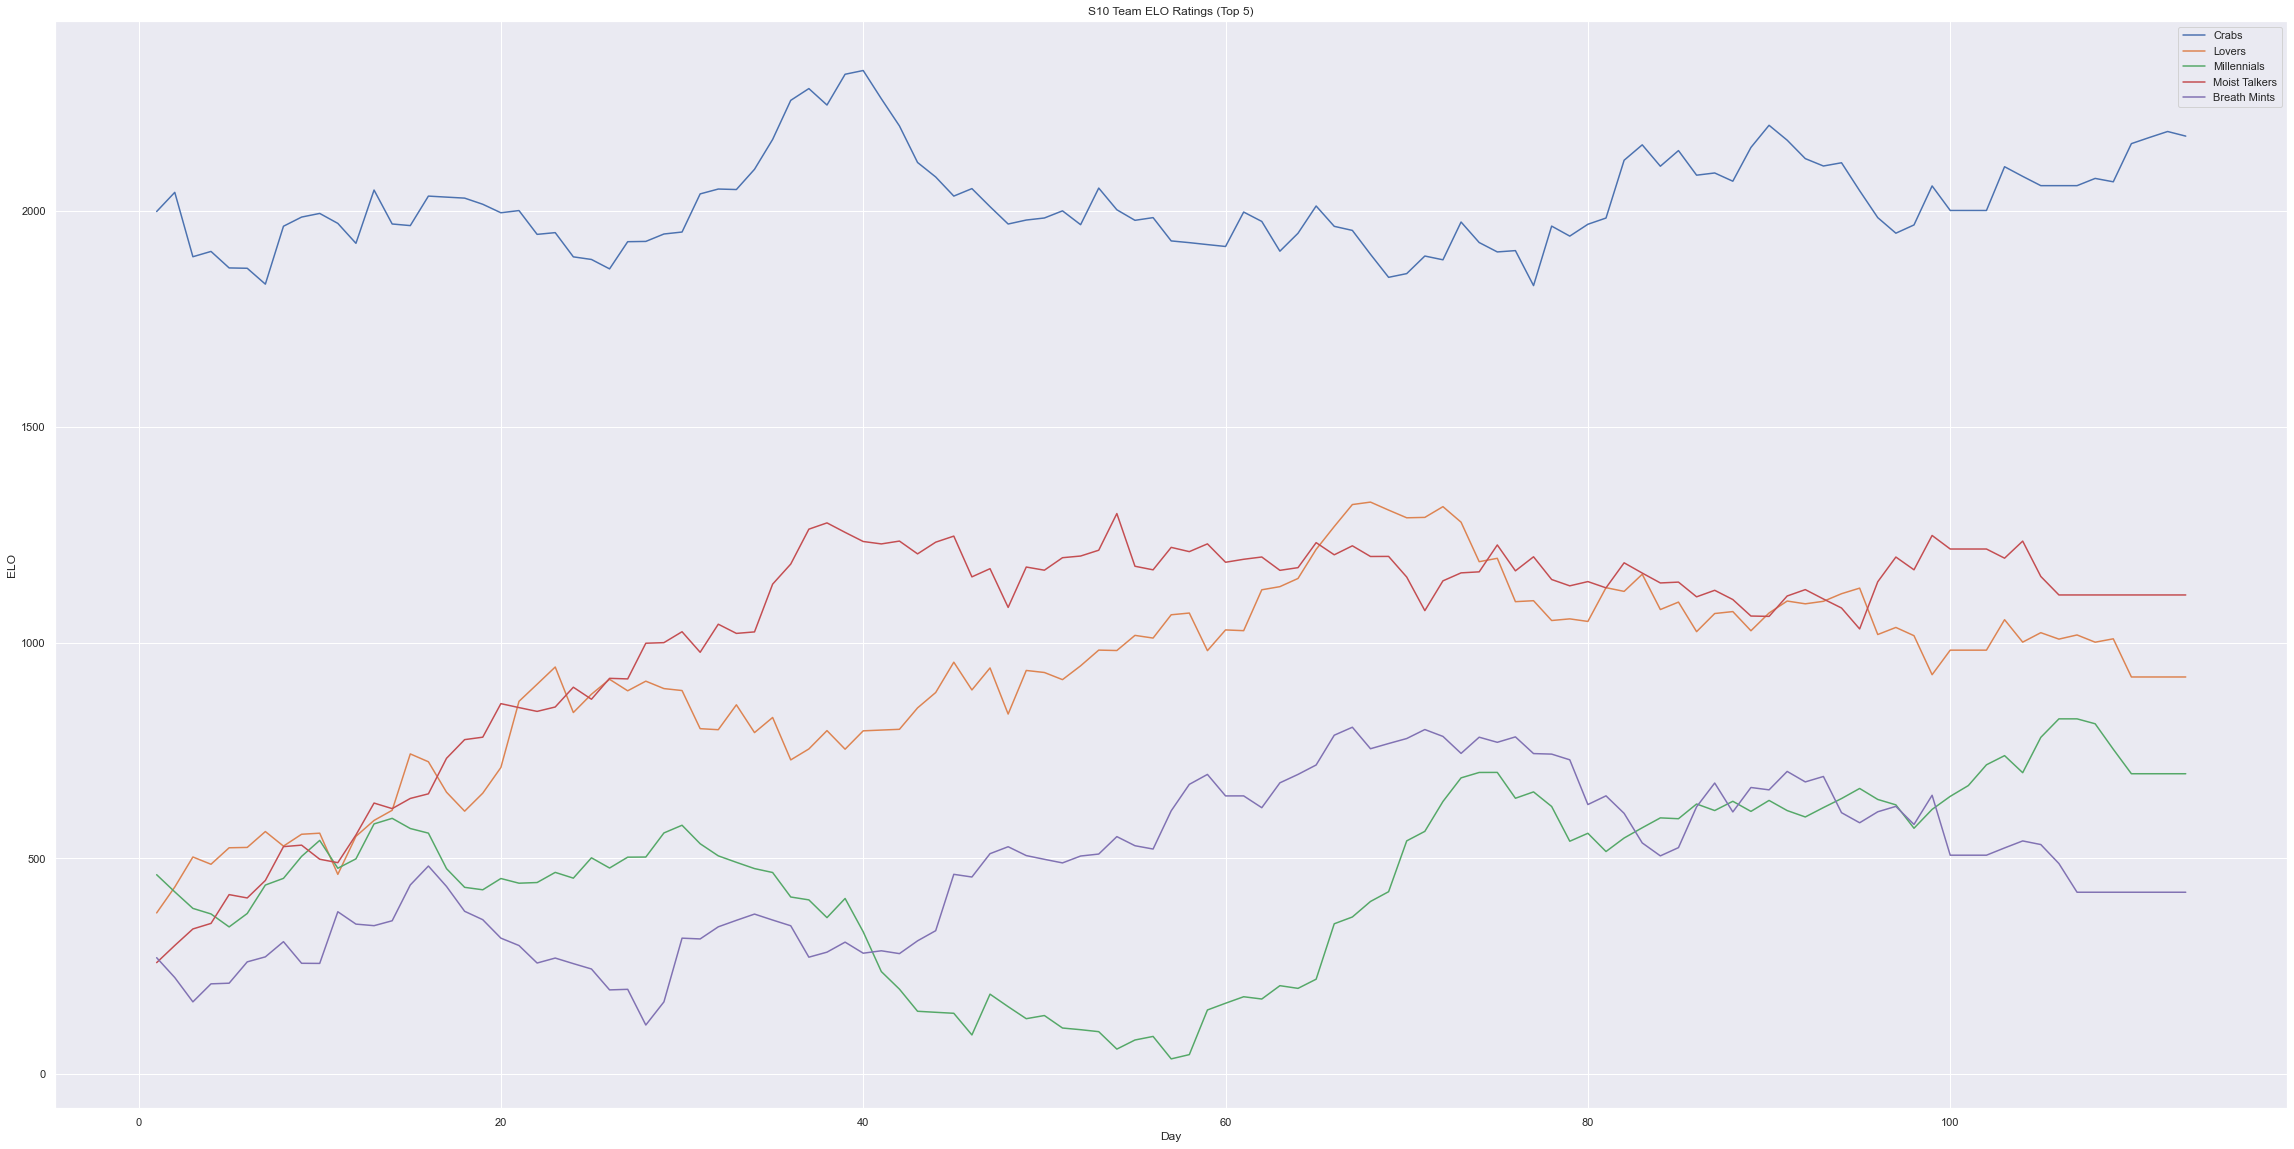

In [89]:
plt.figure(figsize=(40,20))
top5 = ['Crabs','Lovers','Millennials','Moist Talkers','Breath Mints']
for team in top5:
    sns.lineplot(x=s10_elo.index, 
                 y=s10_elo[team], 
                 palette = sns.color_palette(colors,team_color_index[team]))
plt.legend(top5, title_fontsize='xx-large')
plt.title('S10 Team ELO Ratings (Top 5)')
plt.xlabel('Day')
plt.ylabel('ELO');

#### Top teams by mean S10 Elo

In [90]:
s10_elo.describe().transpose()['mean'].sort_values(ascending=False)

incorrect_preds          3650.681416
Crabs                    2019.668363
Tigers                   1120.802236
Moist Talkers            1030.067385
Shoe Thieves              932.693854
Lovers                    928.012751
Spies                     919.205111
Pies                      750.666831
Flowers                   514.026415
Worms                     500.000000
Georgias                  500.000000
Lift                      500.000000
Mechanics                 500.000000
Breath Mints              484.381743
Garages                   464.680192
Millennials               462.419864
Firefighters              435.969744
Sunbeams                  315.839602
Tacos                     311.532254
Steaks                    214.933555
Jazz Hands                200.326866
Wild Wings                 84.374051
Dale                       72.390335
day                        56.097345
season                     10.000000
daily_incorrect_preds       3.752212
Fridays                  -597.407518
M

Season 14 Elo Ratings

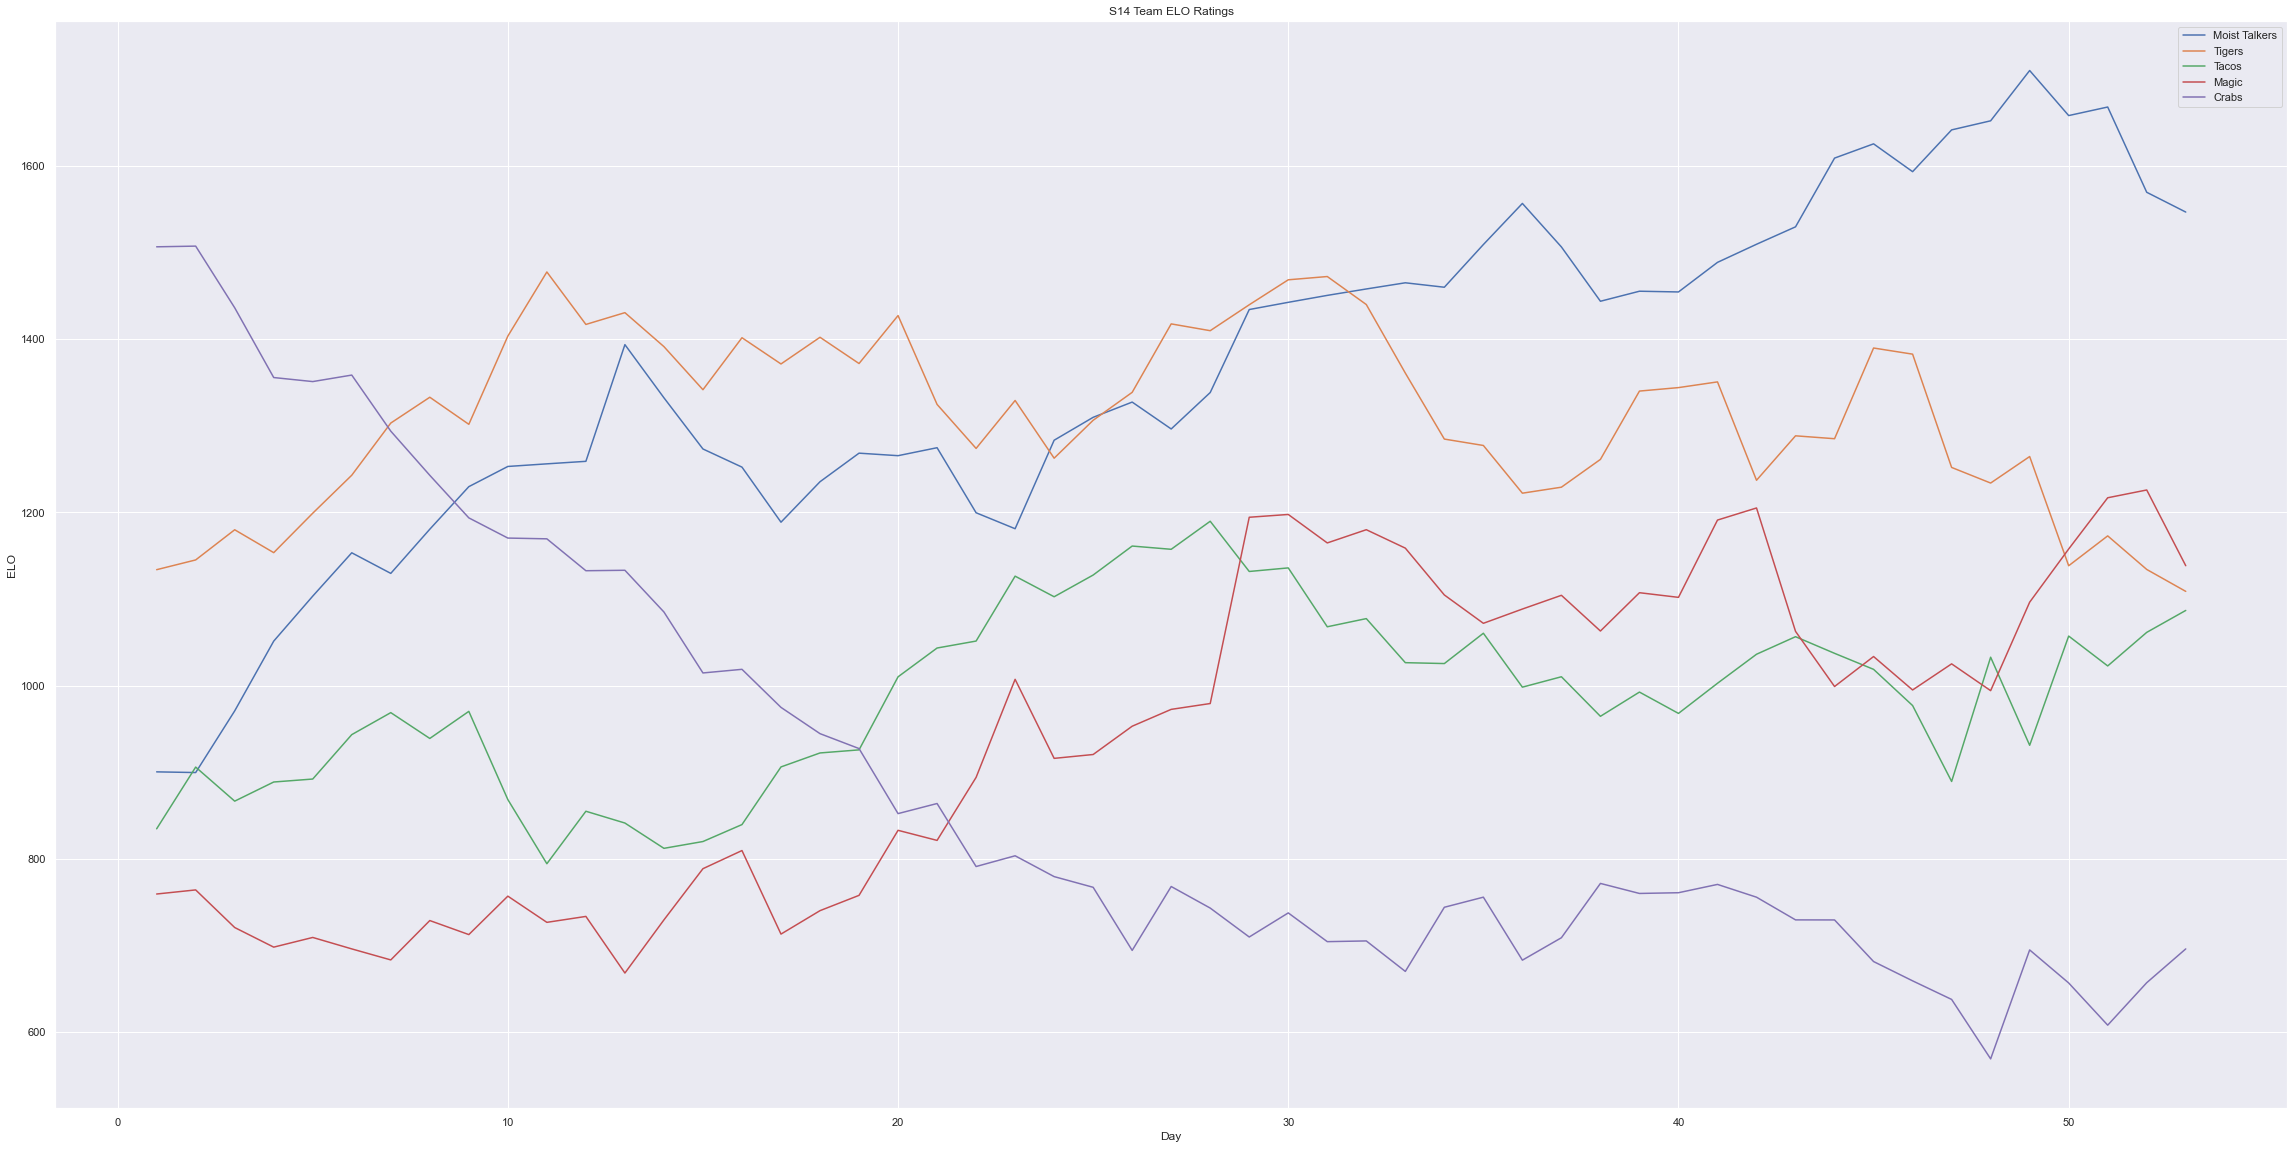

In [103]:
s14_elo = new_elo_table[new_elo_table['season'] == 14]
s14_elo.reset_index(inplace=True,drop=True)
s14_elo.index += 1

plt.figure(figsize=(40,20))
for i, team in enumerate(['Moist Talkers','Tigers','Tacos','Magic','Crabs']):
    sns.lineplot(x=s14_elo.index, y=s14_elo[team], palette = sns.color_palette(colors,i))
plt.legend(['Moist Talkers','Tigers','Tacos','Magic','Crabs'], title_fontsize='xx-large')
plt.title('S14 Team ELO Ratings')
plt.xlabel('Day')
plt.ylabel('ELO');

In [94]:
s14_elo.describe().transpose()['mean'].sort_values(ascending=False)

incorrect_preds          5431.622642
Moist Talkers            1363.289891
Tigers                   1310.877379
Tacos                     989.272724
Magic                     944.681586
Crabs                     894.929222
Lovers                    782.771597
Pies                      705.204926
Firefighters              695.445579
Fridays                   635.673546
Breath Mints              630.535978
Flowers                   479.054971
Mechanics                 477.357964
Dale                      456.930392
Sunbeams                  454.784358
Spies                     432.412264
Garages                   382.242421
Millennials               344.860292
Wild Wings                326.283662
Steaks                    313.245023
Lift                      313.226869
Shoe Thieves              262.872371
day                        26.000000
season                     14.000000
daily_incorrect_preds       5.094340
Jazz Hands                -19.926558
Georgias                 -451.296237
W

S13 Elo

In [105]:
s13_elo = new_elo_table[new_elo_table['season'] == 13]
s13_elo.reset_index(inplace=True,drop=True)
s13_elo.index += 1
s13_elo.describe().transpose()['mean'].sort_values(ascending=False)

incorrect_preds          5063.741379
Crabs                    1518.036730
Moist Talkers            1153.956421
Tigers                   1136.651644
Spies                     911.710549
Fridays                   850.834078
Magic                     776.774030
Firefighters              715.792347
Tacos                     694.913767
Wild Wings                636.409715
Pies                      613.810465
Millennials               594.478044
Sunbeams                  553.537363
Garages                   533.848441
Dale                      475.563623
Flowers                   464.054383
Breath Mints              386.339336
Shoe Thieves              372.350659
Lovers                    270.556302
Steaks                    241.928383
Mechanics                 229.746582
Jazz Hands                211.374562
day                        57.568966
season                     13.000000
daily_incorrect_preds       4.525862
Georgias                 -232.159570
Lift                     -431.835766
W